# Working with Vector Data

<br>

This tutorial is to get you started with spatial analysis of vector data and to apply the knowledge of coordinate systems and attribute tables you gained in the previous tutorials.

The tutorial’s objectives include learning how to:
* Execute spatial queries
* Merge geometries
* Create and use buffers
* Apply spatial overlays
* Use nearest neighbour analysis

These tools will be applied to a typical spatial analysis you might encounter in the energy field – power plant siting. We will work towards establishing the best locations for a solar power plant in the country you have chosen last time.

A plant should be located in an area with relatively easy access (roads nearby), preferably not too far from an existing electric grid and near a population centre. Here we opt for a small or medium-size town/city as the preferred location for our new development.

As a result, we will work with the following assumptions:
* The plant is to be located at a maximum of 5 km from the major roads
* Within 50 km of the nearest town with a population above 10,000
* Within a maximum distance from existing or planned electric grid proportional to line voltage.

Note: these assumptions will vary depending on the project, and are by no means standard

<br>

Further Reading/Resources:
* Geocomputation in R: spatial operations - https://geocompr.robinlovelace.net/spatial-operations.html
* Introution to vector operations in R - https://mgimond.github.io/Spatial/vector-operations-in-r.html#subsetting
* Good discussion around terminology of sf objects - https://www.jessesadler.com/post/simple-feature-objects/

<br>

## Analysis Preparation

### Imports

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use ```install.packages(c("sf", "ggplot2"))```. We'll also get back some information about the packages and any potential issues.

In [8]:
library(sf) # for handling spatial features
library(dplyr) # used for data manipulation
library(raster) # useful in some spatial operations
library(ggplot2) # for plotting
library(zeallot) # used for unpacking variables

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

<br>

### Loading Data

We'll start by downloading the necessary data, note that if you have already downloaded this data it will not be over-written

In [2]:
download_data()

<br>

Now we can read in the country border

In [3]:
df_country <- read_sf('../data/zambia/zambia.shp')

df_country

ID,CODE,COUNTRY,areaQ,geometry
761,ZAM,Zambia,777795418089,"POLYGON ((716452.6 8516873,..."


<br>

To check everything has worked we'll visualise the geometry column

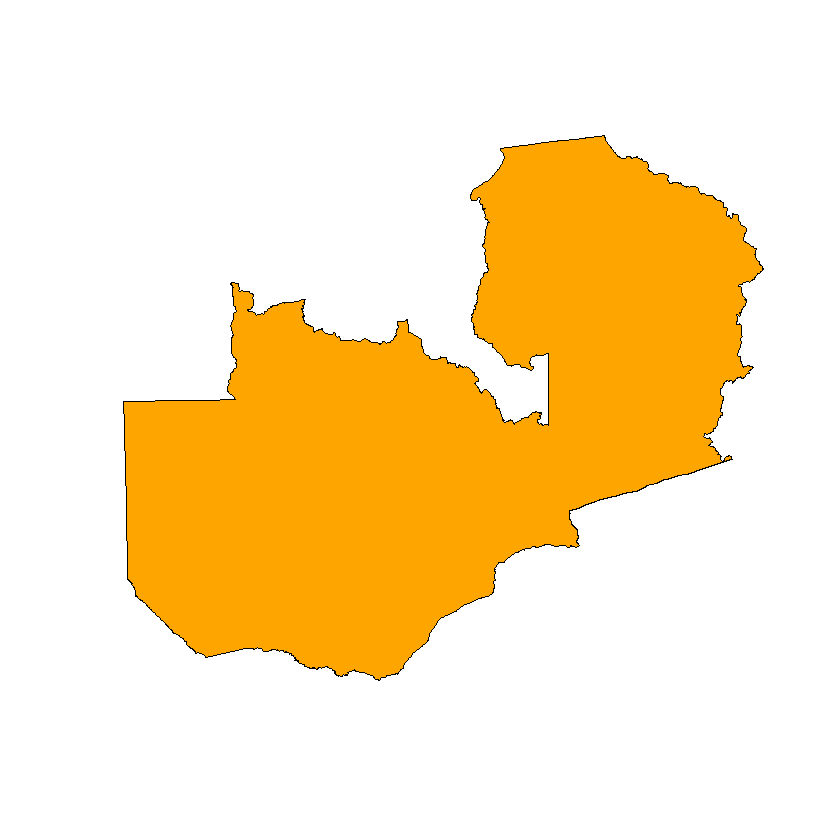

In [9]:
plot(df_country['geometry'], col='orange')

<br>

We'll also check that the CRS is suitable

In [10]:
st_crs(df_country)

Coordinate Reference System:
  User input: Arc 1950 / UTM zone 35S 
  wkt:
PROJCRS["Arc 1950 / UTM zone 35S",
    BASEGEOGCRS["Arc 1950",
        DATUM["Arc 1950",
            ELLIPSOID["Clarke 1880 (Arc)",6378249.145,293.4663077,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4209]],
    CONVERSION["UTM zone 35S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",27,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PARAMETER["False

<br>

As mentioned in the previous tutorial UTM 35S is a suitable selection for Zambia as the country spans its bounding box, UTM CRS' are also a relatively standard set to use.

The image below shows how that for certain regions - for example in the east - it may be more suitable to use UTM36/34S, however as we're analysing data for the whole country we'll stick with UTM35S.

<center><img src="../img/md/zambia_crs.png" width="400"></img></center>

<br>

We'll now read in the countries, cities, roads, and the electricity grid shapefiles spanning the entire African continent.

In [11]:
df_africa_countries <- read_sf('../data/africa/countries.shp')
df_africa_cities <- read_sf('../data/africa/cities.shp')
df_africa_roads <- read_sf('../data/africa/roads.shp')
df_africa_grid <- read_sf('../data/africa/grid.shp')

<br>

We can use *geom_sf* to nicely visualise sf objects with ggplot. It will automatically use *stat_sf* to ensure that all objects are visualised in the same coordinate system, regardless of their individual CRSs. By default the CRS that will be used is the CRS attached to the first sf object plotted, a geographic lon/lat projection is then added as a background.

In this example we'll manually specify *coords_sf* so that we can narrow the plot down to the area we're interested in, rather than the whole of Africa. We'll also add a theme that will put the map on a transparent background.

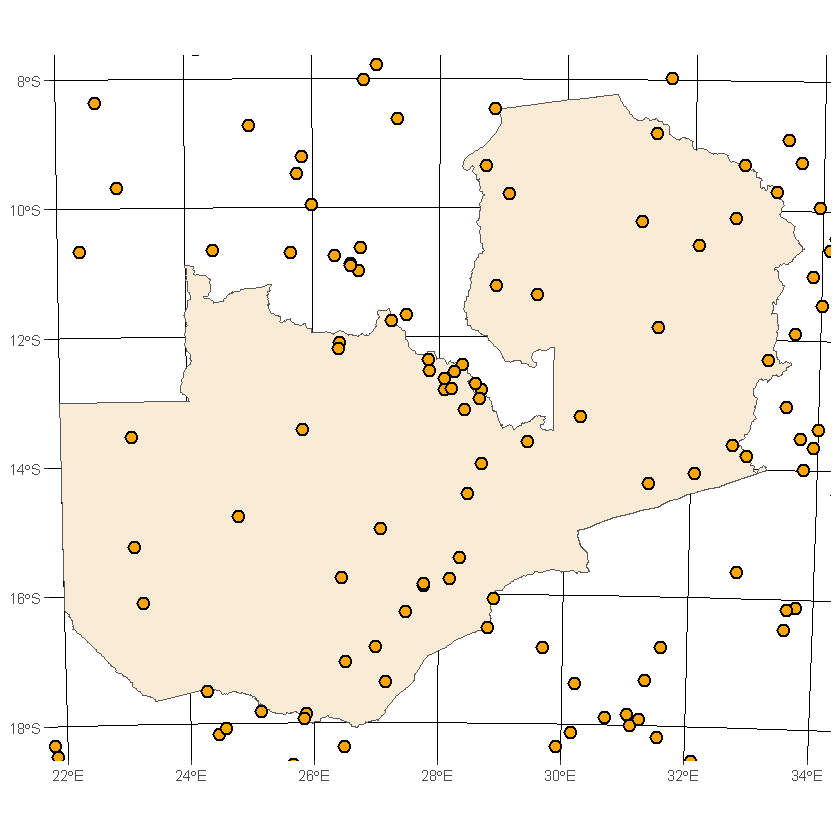

In [12]:
transparent_theme <- theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill='transparent', colour=NA),
    plot.background = element_rect(fill='transparent', colour=NA)
)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_africa_cities, shape=21, 
            color='black', fill='orange', size=3, stroke=1) + 
    coord_sf(xlim=c(0, 1220000), 
             ylim=c(8000000, 9100000)) +
    transparent_theme

<br>

In the previous step we manually specified the plot limits for the area we are interested in. Included in the course helper functions is ```get_geo_df_plot_lims``` which will accept a spatial dataframe and return the limits associated only the objects in that dataset, an example can be seen below. 

A detailed explanation of how this is generated can be found in the extension resource 'Mapping with ggplot' in the section on 'Identifying Spatial Plotting Limits'.

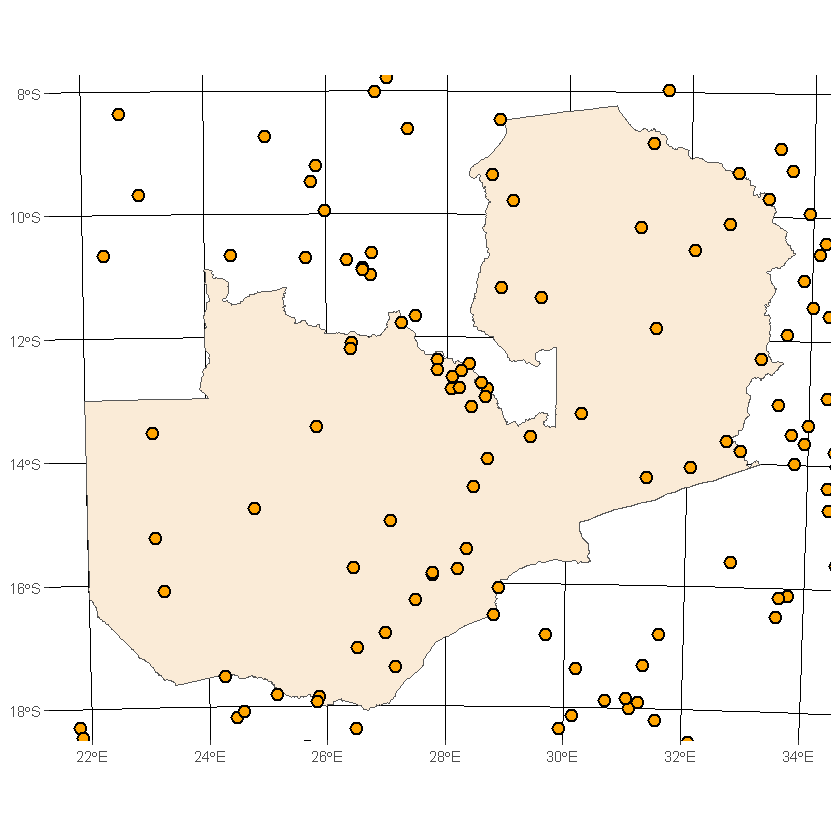

In [13]:
coord_lims <- get_geo_df_plot_lims(df_country)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_africa_cities, shape=21, 
            color='black', fill='orange', size=3, stroke=1) + 
    coord_lims + 
    transparent_theme

<br>

### Standardising the DataFrame CRSs

Before we move on with our analysis we'll make new copies of the africa-wide datasets that are in the CRS used by our selected country. We'll use another of the course helper functions - that extracts the epsg code from a spatial dataframe - to identify the CRS used for the cities

In [14]:
epsg <- extract_epsg_from_df(df_africa_cities)

epsg

[1] 4326

<br>

Unlike the country specific shapefile we read in earlier which is in the CRS EPSG:20935 (i.e. UTM35S), the africa-wide shapefiles are in EPSG:4326 (i.e. lon/lat).

We'll now extract the epsg codes from each of the new dataframes to check what CRS they're in as well. To do this we'll define a function that loops over each of the dataframes, extracts their epsg code, then appends it to a list.

In [15]:
extract_epsg_from_dfs <- function(dfs) {
    epsgs <- list() # We'll create an empty list which 
                    # the epsg codes will be put into
    
    for (df in dfs) # We'll then loop over all of the 
                    # dataframes we've just loaded
    {
        epsg <- extract_epsg_from_df(df) # Extract each epsg code
        epsgs <- append(epsgs, c(epsg))  # and append it to the epsgs list
    }
    
    return(epsgs)
}

dfs <- list(df_africa_cities, df_africa_roads, df_africa_grid)
epsgs <- extract_epsg_from_dfs(dfs)

epsgs

[[1]]
[1] 4326

[[2]]
[1] 4326

[[3]]
[1] 4326

<br>

We can see that the roads and grid dataframes are in EPSG:4326 (lon/lat) as well, so we'll convert them all to UTM35S.

To transform the coordinates of a dataframe from one CRS to another requires the use of the *st_transform* function, which as well as the dataframe must be passed the new CRS that is to be used.

In [16]:
df_africa_cities_UTM35S <- st_transform(df_africa_cities, crs=st_crs(20935))
df_africa_roads_UTM35S <- st_transform(df_africa_roads, crs=st_crs(20935))
df_africa_grid_UTM35S <- st_transform(df_africa_grid, crs=st_crs(20935))

dfs <- list(df_africa_cities_UTM35S, df_africa_roads_UTM35S, df_africa_grid_UTM35S)
epsgs <- extract_epsg_from_dfs(dfs)

epsgs

[[1]]
[1] 20935

[[2]]
[1] 20935

[[3]]
[1] 20935

<br>

## Spatial Queries

In the previous tutorial, we have learned how to select features by attributes (tabular queries). Now, we will select them by spatial relationship. 

Spatial queries answer questions such as:
* Where is … ?
* Where’s the closest … ?
* What’s inside … ?
* What intersects … ?

<br>

### Filtering

We'll start by filtering for Points that fall within a specified Polygon. A good example of where this sort of question can be useful is in finding which countries the cities we have data for are located, where in our case the names of the countries in ```df_africa_countries``` do not fully match those in ```df_africa_cities``` (here ~13% remain unmatched).

In [13]:
non_matching_countries <- setdiff(df_africa_countries$NAME, df_africa_cities$COUNTRY)
pct_countries_unmatched <- round(100*length(non_matching_countries)/nrow(df_africa_countries), 2)

pct_countries_unmatched

[1] 12.96

<br>

We can use ```st_intersects``` to return TRUE/FALSE values for every geometry based on whether they intersect with the other geometries

In [14]:
intersected_cities_bool <- st_intersects(df_africa_cities_UTM35S, df_country, sparse=FALSE)

head(intersected_cities_bool)

FALSE
FALSE
FALSE
FALSE
FALSE
FALSE


<br>

We can then extract the indexes of cities that do intersect with our country of interest

In [15]:
intersected_cities_idxs <- which(intersected_cities_bool)

head(intersected_cities_idxs)

[1] 4254 4255 4256 4257 4258 4259

<br>

We can do a quick check to confirm that at least one of the cities is in Zambia

In [16]:
idx <- intersected_cities_idxs[1]

df_africa_cities_UTM35S[idx, 'COUNTRY']

COUNTRY,geometry
Zambia,POINT (617646.2 8601614)


<br>

We can also plot all of the values on top of our country

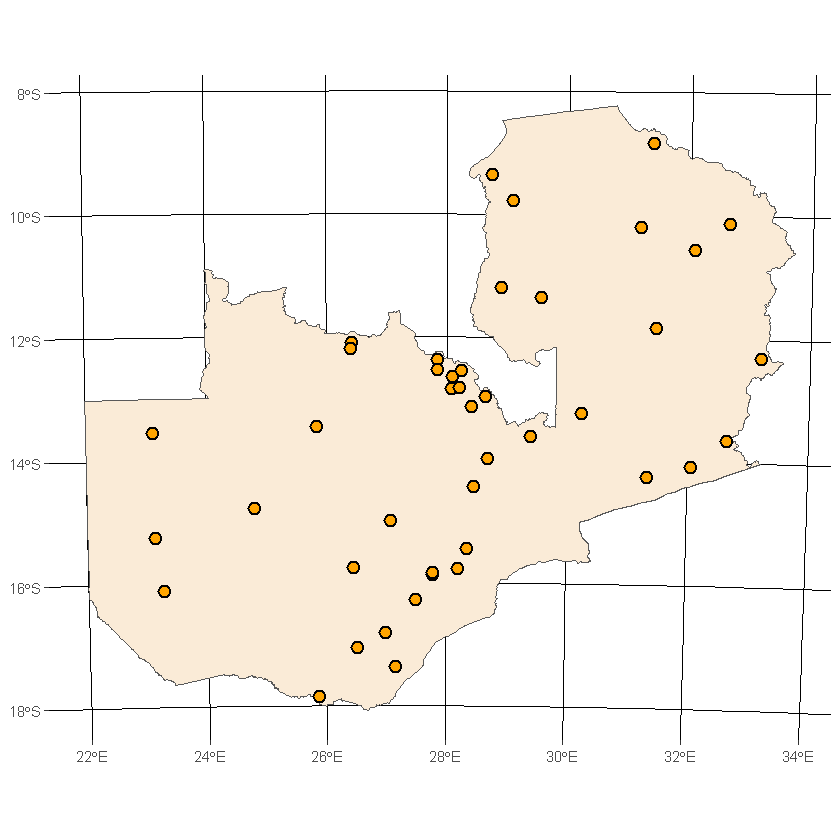

In [17]:
df_zambia_cities_UTM35S <- df_africa_cities_UTM35S[intersected_cities_idxs, ]

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_zambia_cities_UTM35S, shape=21, 
            color='black', fill='orange', size=3, stroke=1) + 
    transparent_theme

<br>



There are a range of functions for producing geometric binary predicates (true/false vectors based on geometric operations), of which ```st_intersects``` is one. The list below outlines the functions available for carrying these out on sf dataframes, further documentation on them can be found <a href="https://r-spatial.github.io/sf/reference/geos_binary_pred.html">here</a>.

```R
st_intersects(x, y, ...)
st_disjoint(x, y, ...)
st_touches(x, y, ...)
st_crosses(x, y, ...)
st_within(x, y, ...)
st_contains(x, y, ...)
st_contains_properly(x, y, ...)
st_overlaps(x, y, ...)
st_equals(x, y, ...)
st_covers(x, y, ...)
st_covered_by(x, y, ...)
st_equals_exact(x, y, ...)
st_is_within_distance(x, y, ...)
```

We'll quickly create a helper function that can speed up our testing of what each of these binary predicate functions do. It accepts the function to be tested, as well as the spatial dataframe objects the function will be used with.

We'll replicate the previous step we carried out with ```st_intersects``` using our new function.

Finally we'll use the ```identical``` function to check that the returned dataframe is the same as the one we filtered on the intersection explicilty ... it is!

In [18]:
filter_geo_predicate <- function(binary_pred_func, x, y){
    binary_predicate <- binary_pred_func(x, y, sparse=FALSE)
    x_filtered <- x[which(binary_predicate), ]
    
    return(x_filtered)
}

df_intersected_cities <- filter_geo_predicate(st_intersects, df_africa_cities_UTM35S, df_country)

identical(df_intersected_cities, df_zambia_cities_UTM35S)

[1] TRUE

<br>

We'll now use a different binary predicate function, ```st_within```, and see if the results it returns are the same as ```st_intersects```. ```st_within``` identifies geometries that fall within another geometry.

In [19]:
df_within_cities <- filter_geo_predicate(st_within, df_africa_cities_UTM35S, df_country)

identical(df_intersected_cities, df_within_cities)

[1] TRUE

<br>

Now let's try using ```st_within``` and ```st_intersects``` with the grid data rather than cities

In [20]:
df_intersects_grid <- filter_geo_predicate(st_intersects, df_africa_grid_UTM35S, df_country)
df_within_grid <- filter_geo_predicate(st_within, df_africa_grid_UTM35S, df_country)

identical(df_intersects_grid, df_within_grid)

[1] FALSE

<br>

Why aren't they the same, unlike when using the cities instead of grid data?

We can look at the number of rows in each dataframe and see that there are an additional 10 when ```st_intersects``` was used instead of ```st_within```.

In [21]:
nrow(df_within_grid)

[1] 118

In [22]:
nrow(df_intersects_grid)

[1] 130

<br>

We can then use ```setdiff(a, b)``` to identify the elements inside ```a``` that aren't in ```b```, in our case the extra indexes included after using ```st_intersects```

In [23]:
within_idxs <- which(st_within(df_africa_grid_UTM35S, df_country, sparse=FALSE))
intersects_idxs <- which(st_intersects(df_africa_grid_UTM35S, df_country, sparse=FALSE))

extra_idxs <- setdiff(intersects_idxs, within_idxs)

extra_idxs

[1]  9005  9052  9299  9400  9534  9657  9670  9708 10596 11463 14205 15918

<br>

When we plot the extra geometries the reason becomes a lot clearer as all of them touch the border.

```st_intersects``` returns all geometries that cross or are inside the Polygon, unlike ```st_within``` which only returns those that are inside the Polygon border.

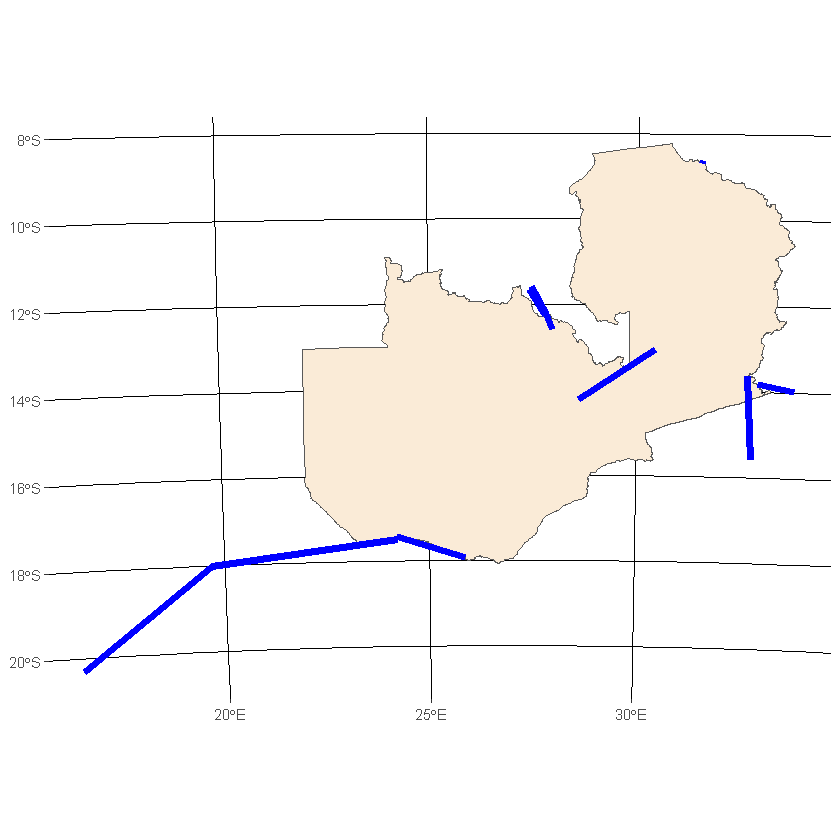

In [24]:
df_grid_intersects_extra <- df_africa_grid_UTM35S[extra_idxs, ]

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_grid_intersects_extra, color='blue', size=2) + 
    transparent_theme

<br>

#### Questions

Now its your turn to try out some of these functions and ask your own spatial queries. As well as exploring these functions on this dataset, make sure to explore other spatial data in your own time.

<br>

##### How many Cities are there in Tanzania?

Count the number of cities that are inside Tanzanian borders

In [25]:
# 

<br>

##### Interconnector Identification

When we determined the difference between the geometries returned by ```st_intersects``` and ```st_within``` we effectively found interconnectors between our country and others. Rather than calculating both of these we could use a single binary predicate function that was mentioned earlier, can you identify which one and then plot the interconnectors?

In [26]:
# 

<br>

### Clipping

We will now select data from the continent-wide files for cities, roads, and electric grid network, and subset them for to the specific spatial area we're interested in

To do this we can use the ```st_intersection``` function.

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"

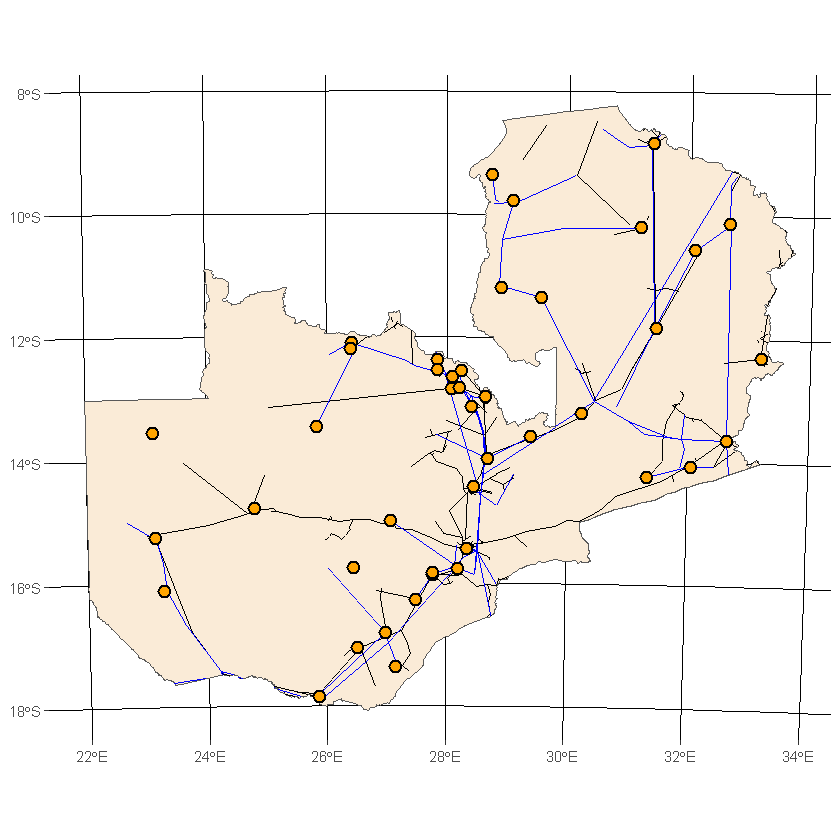

In [27]:
df_country_cities <- st_intersection(df_country, df_africa_cities_UTM35S)
df_country_grid <- st_intersection(df_country, df_africa_grid_UTM35S)
df_country_roads <- st_intersection(df_country, df_africa_roads_UTM35S)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_country_roads, color='black') + 
    geom_sf(data=df_country_grid, color='blue') + 
    geom_sf(data=df_country_cities, shape=21, 
            color='black', fill='orange', size=3, stroke=1) + 
    transparent_theme

<br>

```st_intersection``` sounds remarkably like ```st_intersects```, lets see if it's just a wrapper for the function we used earlier. To do this we'll create an alternative function that acts as a wrapper for ```st_intersects```.

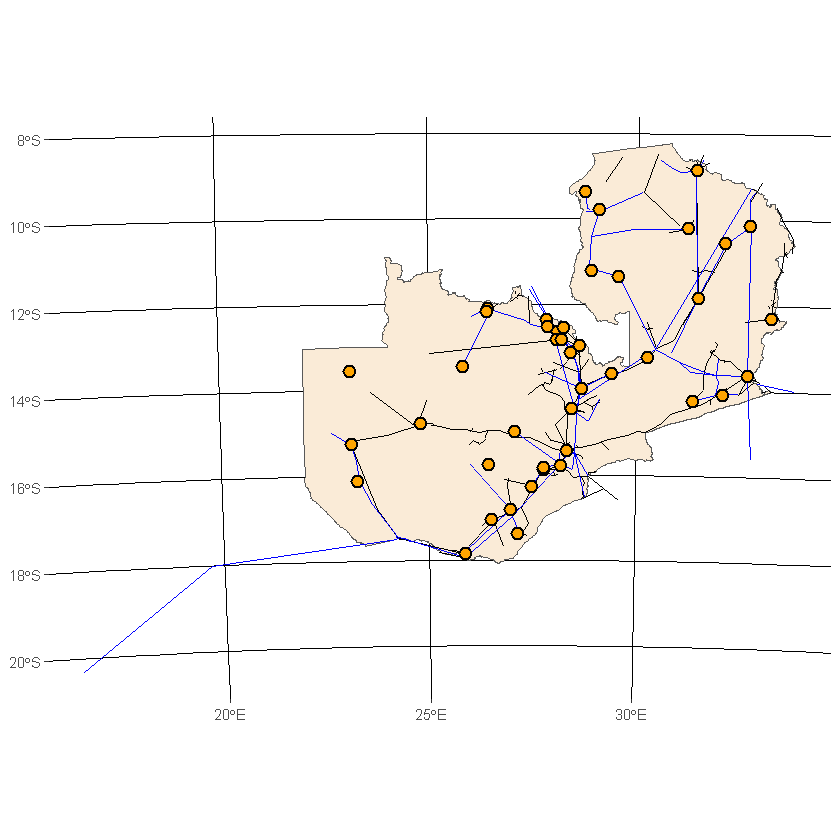

In [28]:
alt_intersection <- function(x, y){
    y_filtered <- filter_geo_predicate(st_intersects, y, x)
    
    return(y_filtered)
}

df_country_cities_alt <- alt_intersection(df_country, df_africa_cities_UTM35S)
df_country_grid_alt <- alt_intersection(df_country, df_africa_grid_UTM35S)
df_country_roads_alt <- alt_intersection(df_country, df_africa_roads_UTM35S)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_country_roads_alt, color='black') + 
    geom_sf(data=df_country_grid_alt, color='blue') + 
    geom_sf(data=df_country_cities_alt, shape=21, 
            color='black', fill='orange', size=3, stroke=1) + 
    transparent_theme

<br>

That's bizarre, we can see that some of our roads and grid lay outside the country in this plot (e.g. to the east), however in the previous one they were cut back. 

Rather confusingly it turns out that ```st_intersection``` is not simply a wrapper for ```st_intersects```, instead it is more accurate to describe it as *clipping* the geometries to the Polygon provided. Clipping involves filtering the geometries (e.g. with ```st_intersects```), then reshaping those that cross the boundary by removing any area that lies outside of it (this can be imagined as similar to a cookie cutter). For more discussion on this see section 5.2.5 of <a href="https://geocompr.robinlovelace.net/geometric-operations.html">Geocomputation with R</a>.

<br>
<br>

### Merging Spatial Features

At the moment, the grid data is composed of many short sections, which could go into hundred of records for a large country. We do not require details on each section separately, instead we can merge them all into a single network. 

We'll start by merging all of the electrical grid Linestrings for our selected country. To do this we can use a function called ```st_union```, which will accept our dataframe then return a single geometry. In this example we'll combine a set of Linestrings into a Multilinestring.

In [29]:
grid_multilinestring <- st_union(df_country_grid)

grid_multilinestring

MULTILINESTRING ((588362.5 8644618, 588361.1 86...


Geometry set for 1 feature 
geometry type:  MULTILINESTRING
dimension:      XY
bbox:           xmin: 34584.09 ymin: 8017022 xmax: 1135935 ymax: 9047022
projected CRS:  Arc 1950 / UTM zone 35S

<br>

That was useful but what if we wanted to dissolve the geometries based on an attribute of the data? We can do this using ```group_by``` and ```summarize``` in combination. Here we'll group them by their voltage, then as well as creating the grouped geometries we'll calculate their total length.

```group_by``` and ```summarize``` are often used together in data analysis tasks - this will be covered in more detail as part of the Energy & Data Analysis module - further information can also be found <a href="https://datacarpentry.org/R-genomics/04-dplyr.html#split-apply-combine_data_analysis_and_the_summarize()_function">here</a>.

N.b. We want to sum the length of each voltage group so we'll have to convert the 'length_km' column from a character to numeric data-type.

In [30]:
df_country_grid <- transform(df_country_grid, length_km=as.numeric(length_km))

df_grid_groups <- df_country_grid %>%
                    group_by(voltage_kV) %>%
                    summarize(length_km=sum(length_km, na.rm=TRUE))

df_grid_groups

voltage_kV,length_km,geometry
0,0,MULTILINESTRING ((237074.3 ...
33,986,MULTILINESTRING ((1041836 8...
66,3718,MULTILINESTRING ((994361.7 ...
88,462,MULTILINESTRING ((662447.9 ...
132,287,MULTILINESTRING ((589924.9 ...
220,737,MULTILINESTRING ((588362.5 ...
330,2755,MULTILINESTRING ((662611.6 ...
350,993,LINESTRING (176705.4 805910...
400,218,LINESTRING (1114177 8424246...


<br>

We can compare these lengths with reported data and see that they are fairly similar.

> <a href="https://openjicareport.jica.go.jp/pdf/11871019.pdf">"total circuit length of 330kV transmission lines is 2,241km, total 220kV lines 348km, total 132kV lines 202km, total 88kV lines 754km and total 66kV lines 3,033km as at the end of March 2006."</a> - Japan International Cooperation Agency

<br>

What about if we wanted to do the reverse operation and convert a Multilinestring into its constituent parts? For this we can recast the datatype back into Linestrings using ```st_cast```.

In [31]:
grid_geom_set <- st_cast(grid_multilinestring, 'LINESTRING')

grid_geom_set

LINESTRING (588362.5 8644618, 588361.1 8644620)
LINESTRING (589924.9 8648093, 589932.7 8648079)
LINESTRING (1135935 8466559, 1135923 8466562)
LINESTRING (1114177 8424246, 1111893 8485588)
LINESTRING (994361.7 9037434, 994367.3 9037461)


Geometry set for 280 features 
geometry type:  LINESTRING
dimension:      XY
bbox:           xmin: 34584.09 ymin: 8017022 xmax: 1135935 ymax: 9047022
projected CRS:  Arc 1950 / UTM zone 35S
First 5 geometries:

<br>

We can also query the length of any individual or collection of Linestrings

In [32]:
st_length(grid_multilinestring)

7917725 [m]

<br>

#### Questions

##### East African Community High Voltage Length

What is the total length of power cable across the East African Community (EAC) that has a voltage of 132 kV or higher? The 6 members of the EAC are Burundi, Kenya, Rwanda, South Sudan, Tanzania, and Uganda.

In [33]:
# 

<br>

##### Space Saving

Another important reason for aggregating spatial data is to reduce its size, by which we mean the amount of storage required to hold the data (nothing to do with spatial size). For example in our grid dataframe each of the 400+ geometries contains information on the CRS, despite them all being the same.

In this task you should identify the reduction in data size between the merged and unmerged road data. You can use ```object.size(x)``` determine the size (in bytes) of any R object.

As an extension task investigate the effects of simplifying your geometries with ```st_simplify```, and how this impacts the object size.

In [34]:
# 

<br>

### Proximity Analysis

#### Buffering

Selecting features by their proximity to other features is one of the most common operations in GIS. Of these the most used approach is buffering the features and then identifying overlaps.

We'll start by asking the question "which areas are within 5km of roads?". To do this we can use the ```st_buffer``` function which accepts both a spatial object and a distance value.

When providing a buffer distance, e.g. 10, the buffering will use the units specified by the CRS. To check what units your CRS is in you can check it using ```st_CRS```, or more easily by looking on <a href="http://epsg.io/20935">epsg.io</a>. To emphasise this point we'll take a single road from the dataframe and buffer it by 5km (using 5000 as UTM35S is in m).

N.b. Regardless of whether the original geometry is a Point, Line or Polygon, the resulting geometry after buffering will always be a Polygon.

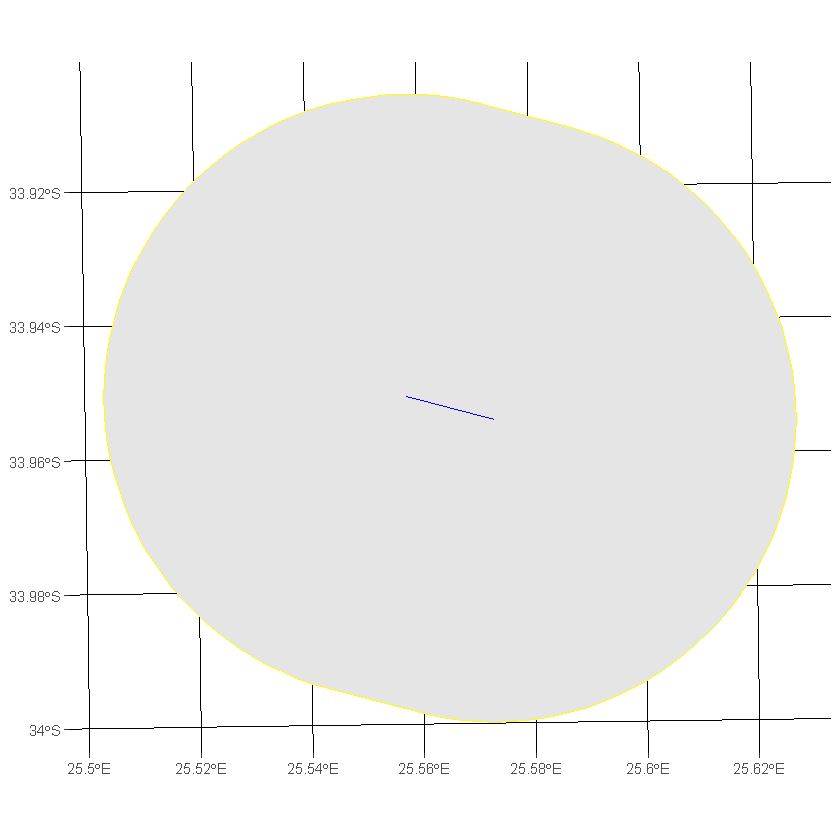

In [35]:
df_road_UTM35S <- df_africa_roads_UTM35S[1, ]
df_buffered_road_UTM35S <- st_buffer(df_road_UTM35S, dist=5000)

ggplot() +
    geom_sf(data=df_buffered_road_UTM35S, color='yellow') + 
    geom_sf(data=df_road_UTM35S, color='blue') + 
    transparent_theme

<br>

If we were to repeat this with the roads dataframe that is in EPSG:4326 we produce very different results, in fact we can't even see the original road. This is because the CRS is in units of degrees rather than metres (approximately the conversion is $0.001^{\circ} \rightarrow 111 m$).

Warning message in st_buffer.sfc(st_geometry(x), dist, nQuadSegs, endCapStyle = endCapStyle, :
"st_buffer does not correctly buffer longitude/latitude data"dist is assumed to be in decimal degrees (arc_degrees).


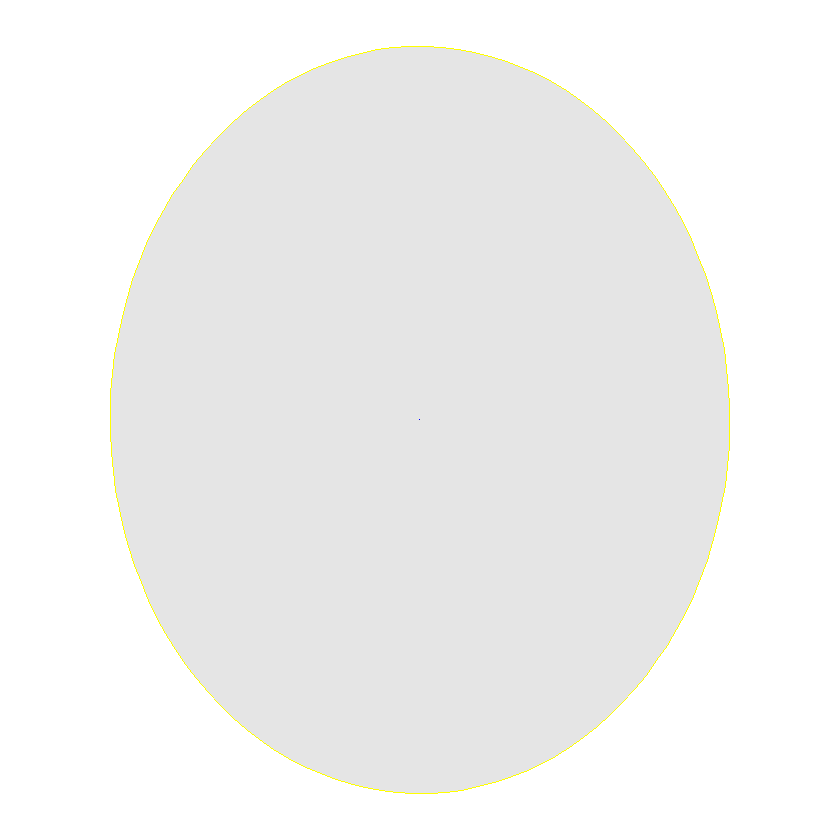

In [36]:
df_road <- df_africa_roads[1, ]
df_buffered_road <- st_buffer(df_road, dist=5000)

ggplot() +
    geom_sf(data=df_buffered_road, color='yellow') + 
    geom_sf(data=df_road, color='blue') + 
    transparent_theme

<br>

We can achieve similar results as with 5km using a buffer distance of only 0.05 degrees. However, it should be noted that it is best to carry out buffering in a projected rather than geographic coordinate system (2D not 3D).

Warning message in st_buffer.sfc(st_geometry(x), dist, nQuadSegs, endCapStyle = endCapStyle, :
"st_buffer does not correctly buffer longitude/latitude data"dist is assumed to be in decimal degrees (arc_degrees).


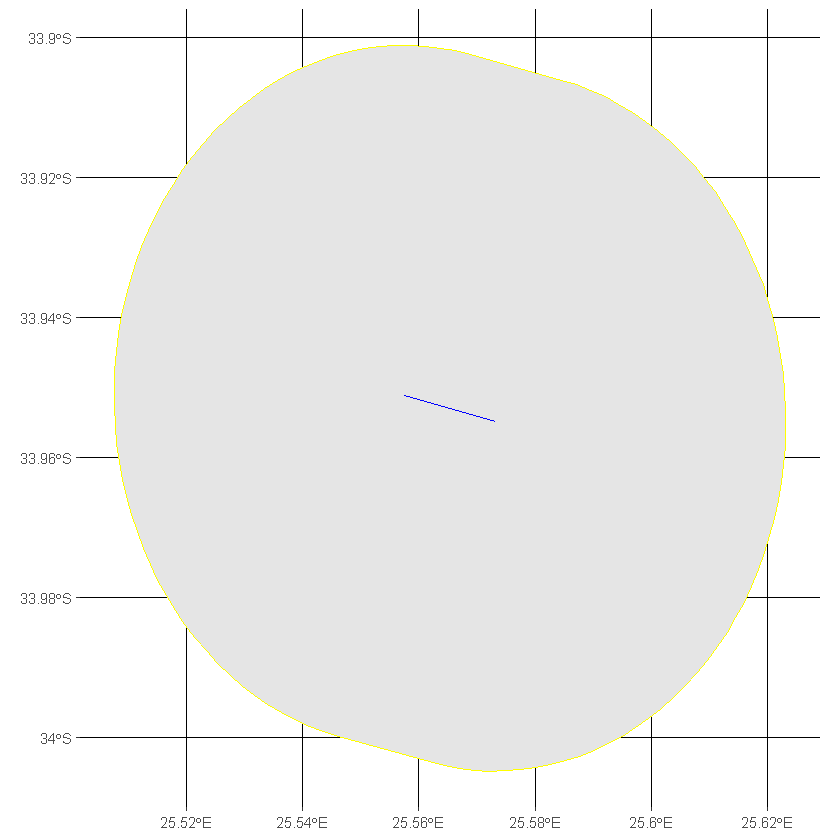

In [37]:
df_road <- df_africa_roads[1, ]
df_buffered_road <- st_buffer(df_road, dist=0.05)

ggplot() +
    geom_sf(data=df_buffered_road, color='yellow') + 
    geom_sf(data=df_road, color='blue') + 
    transparent_theme

<br>

We're now ready to ask the question we were interested in, namely what areas are within 5km of roads? to speed up the analysis we'll first combine it into a single Multipolygon.

<font color='red'>N.b. Depending on the size of your country and how many roads it contains this may take up to a few minutes</font>

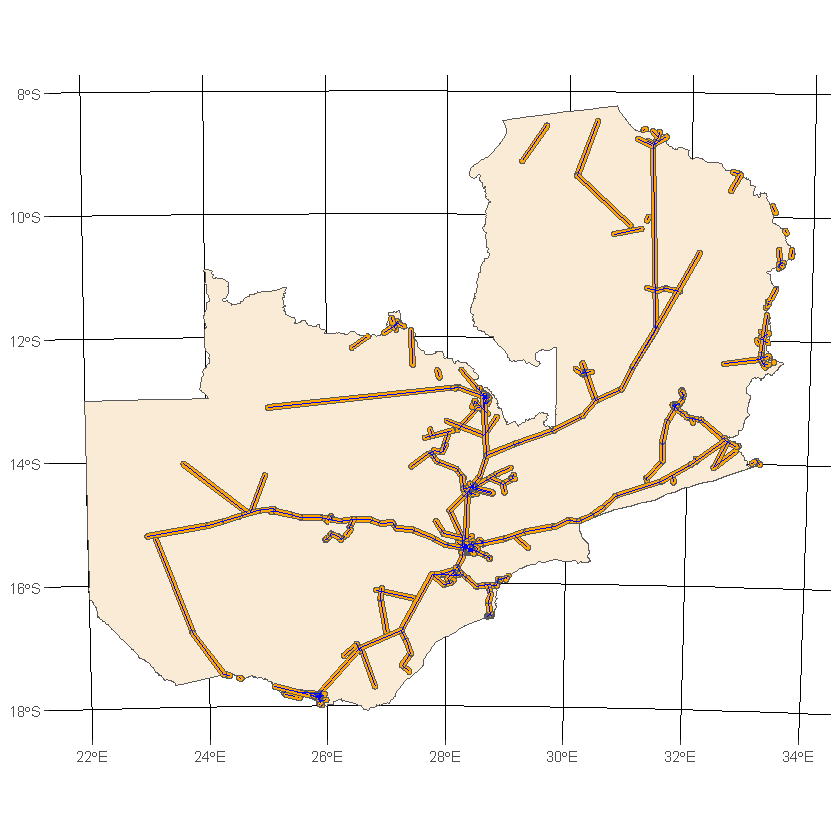

In [38]:
df_buffered_roads <- st_buffer(df_country_roads, dist=5000)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_buffered_roads, fill='orange') + 
    geom_sf(data=df_country_roads, color='blue') + 
    transparent_theme

<br>

We'll repeat the same operation for the cities, except using 50km instead of 5km

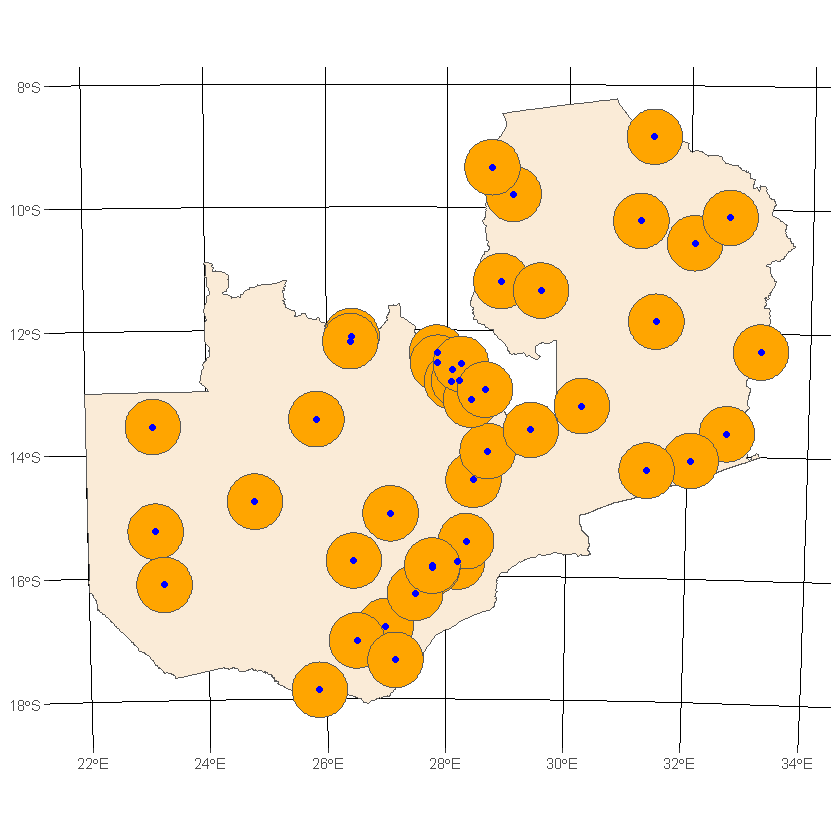

In [39]:
df_buffered_cities <- st_buffer(df_country_cities, dist=50000)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_buffered_cities, fill='orange') + 
    geom_sf(data=df_country_cities, color='blue') + 
    transparent_theme

<br>

Hmm, we could definitely take a smarter approach. Let's instead buffer cities that have a population greater than 10,000, then combine the resulting Polygons into a single geometry.

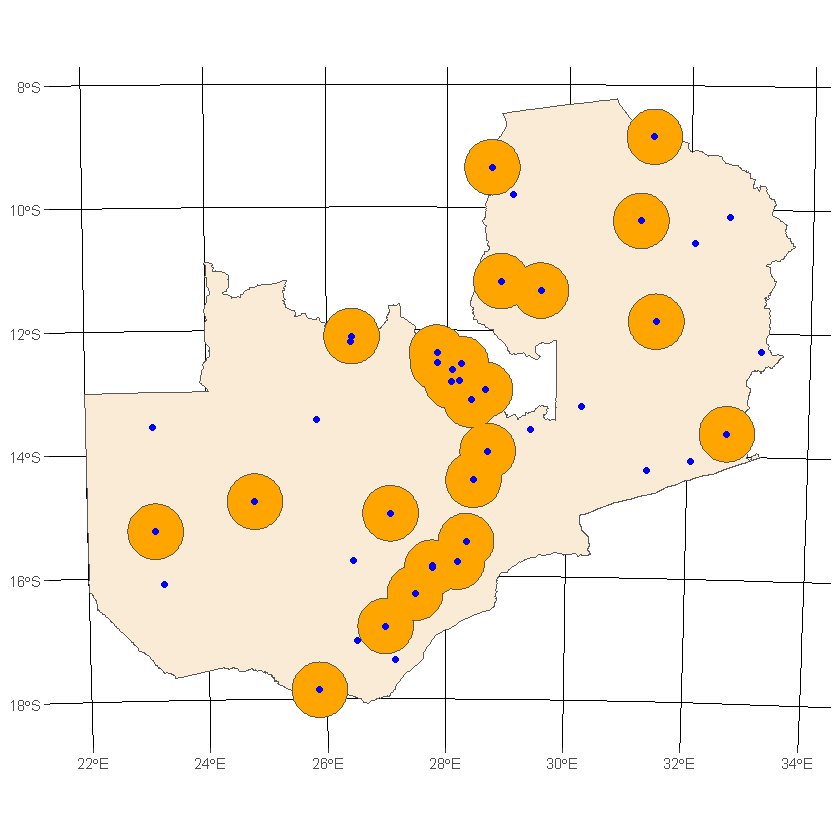

In [40]:
df_country_big_cities <- df_country_cities[df_country_cities$ES00POP>10000, ]
df_buffered_cities <- st_buffer(df_country_big_cities, dist=50000)
df_buffered_cities_comb <- st_union(df_buffered_cities)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_buffered_cities_comb, fill='orange') + 
    geom_sf(data=df_country_cities, color='blue') + 
    transparent_theme

<br>

So far we have buffered all of our spatial features by a constant distance, often though we want to be more specific than that, especially when we want to buffer based on an attribute of the spatial features. A good example of this is in buffering the electricity grid - instead of using the same buffer for 33 kV lines as we do for say 400 kV ones we could buffer based on the voltage.

Here we'll buffer the grid by taking a distance 20x the voltage, as the distance used by the buffer is the radius (not diameter) we should provide a value equal to 10x the value to ```st_buffer```. The key learning here is that ```st_buffer``` can accept either a constant, or a vector equal in length to the dataframe passed to it.

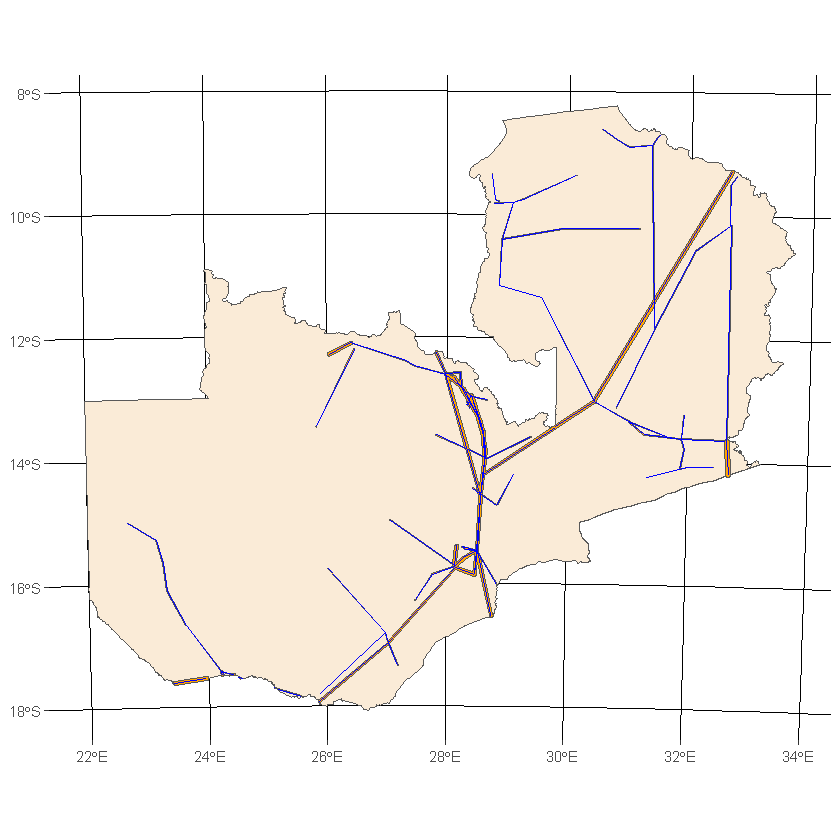

In [41]:
dist <- df_country_grid$voltage_kV * 10
df_buffered_grid <- st_buffer(df_country_grid, dist=dist)
df_buffered_grid_comb <- st_union(df_buffered_grid)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_buffered_grid_comb, fill='orange') + 
    geom_sf(data=df_country_grid, color='blue') + 
    transparent_theme

<br>

#### Spatial Overlays

As previously discussed, spatial query operations subset the data in one dataset only, it changes their extent but not their attributes. To combine data from two sources based on their spatial relationship we need to use an overlay
operation.

We previously covered ```st_intersection``` but now we'll go deeper into the other options available to us (shown in the diagram below). For completeness though we'll start by taking the intersection of the grid and cities buffers.

<img src="../img/md/spatial_overlays.jpg"></img>

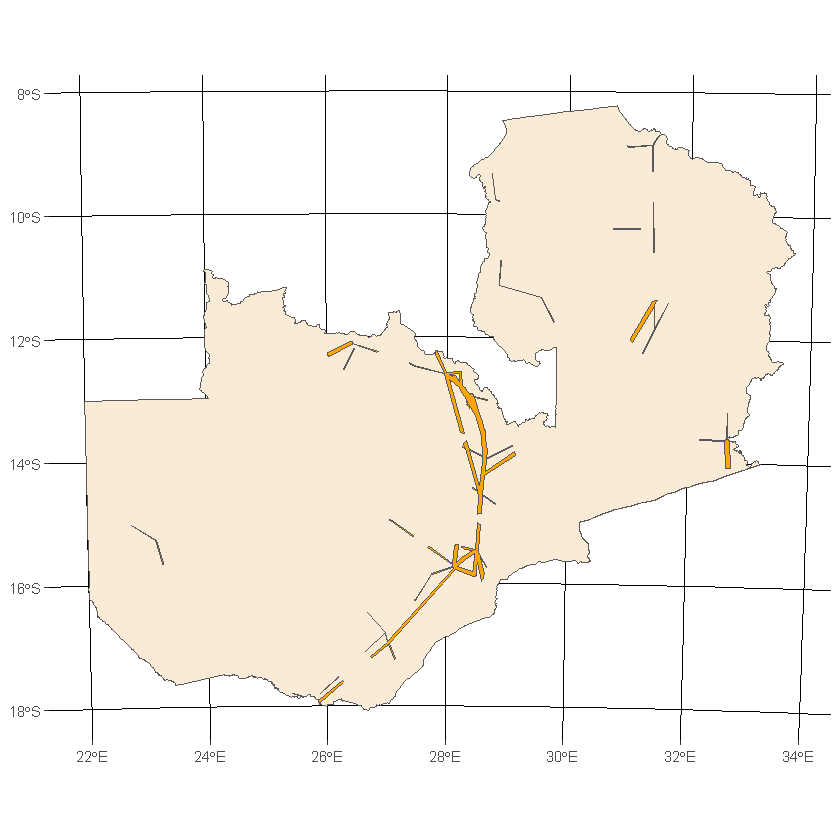

In [42]:
df_grid_cities_intersection <- st_intersection(df_buffered_grid_comb, df_buffered_cities_comb)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_grid_cities_intersection, fill='orange') + 
    transparent_theme

<br>

The union contains the combined geometries from both datasets

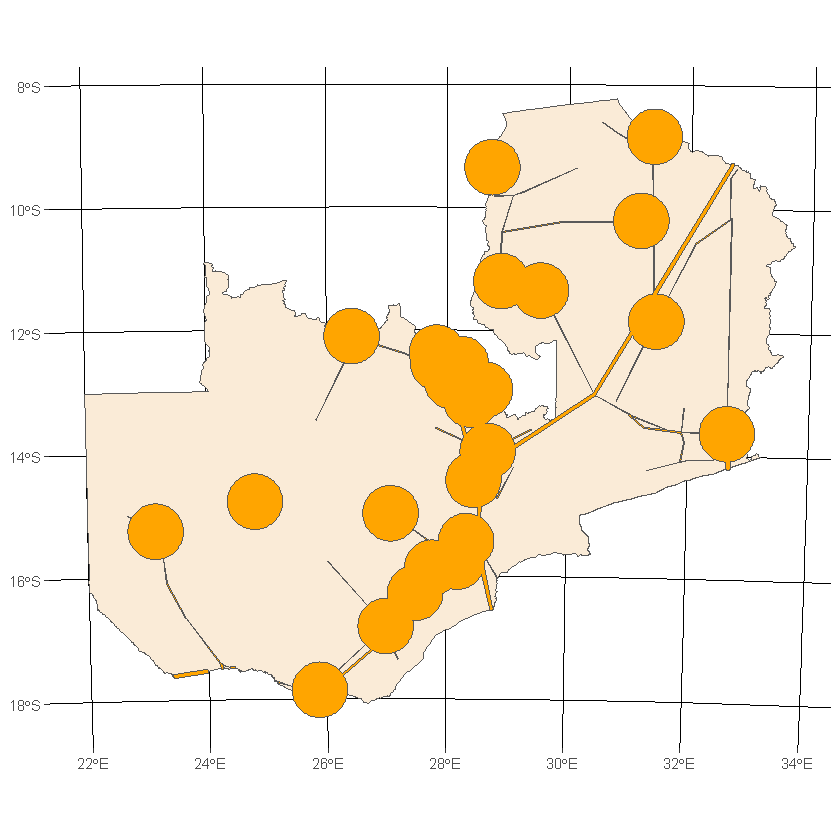

In [43]:
df_grid_cities_union <- st_union(df_buffered_grid_comb, df_buffered_cities_comb)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_grid_cities_union, fill='orange') + 
    transparent_theme

<br>

Looking now at the country and buffered cities datasets we'll test ```st_difference```, where the output contains all areas of the first input that do not overlap with the second

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"

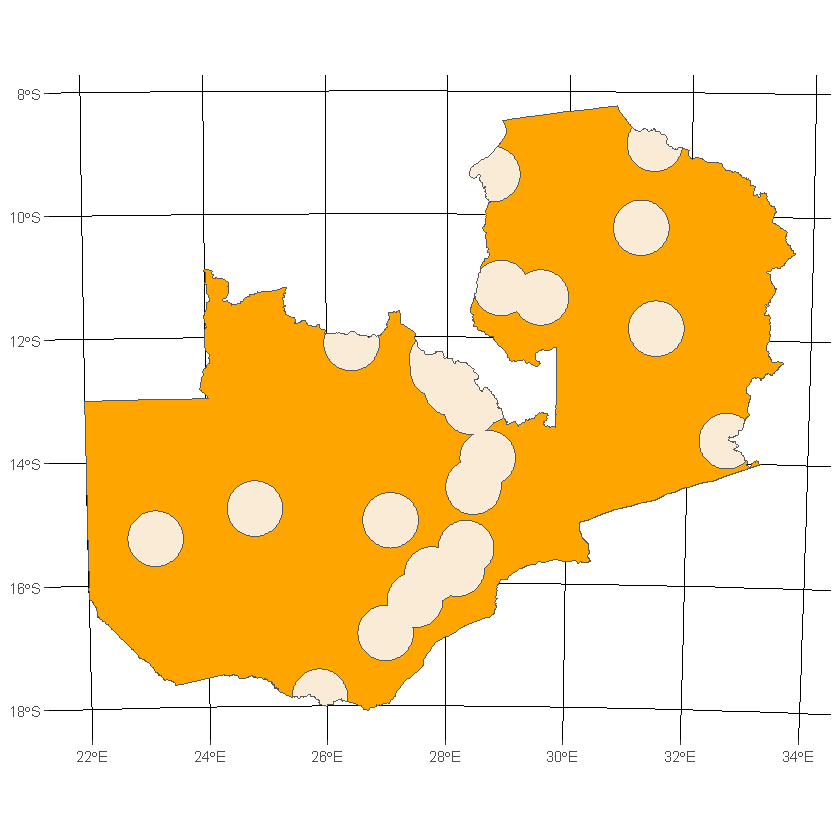

In [44]:
df_country_cities_diff<- st_difference(df_country, df_buffered_cities_comb)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_country_cities_diff, fill='orange') + 
    transparent_theme

<br>

Taking the symmetrical difference of the same datasets returns all areas where the two input geometries do not overlap

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"

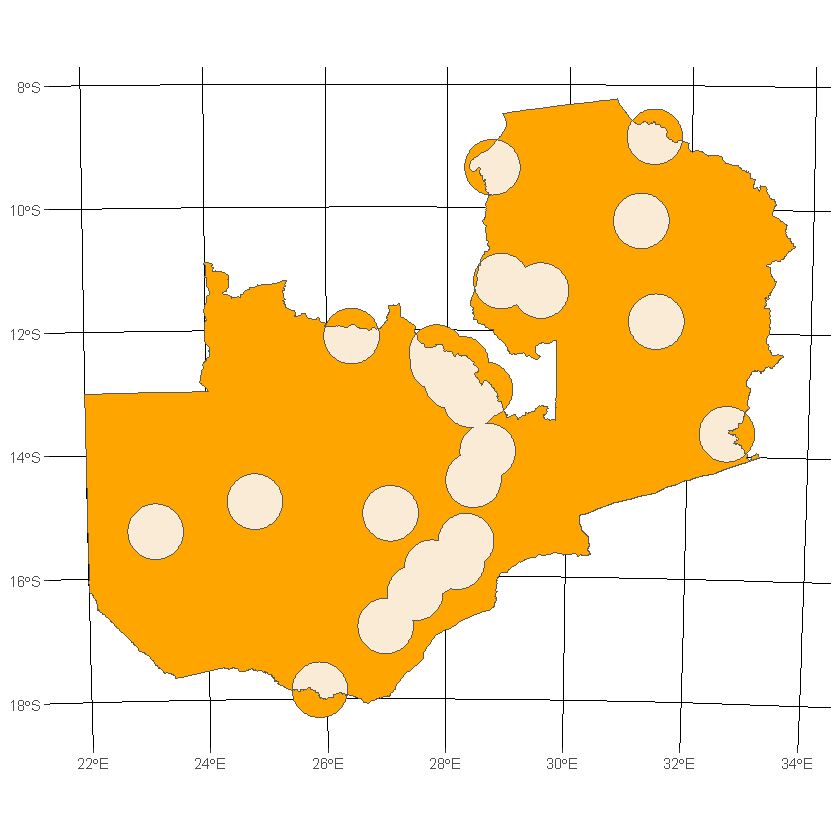

In [45]:
df_country_cities_sym_diff <- st_sym_difference(df_country, df_buffered_cities_comb)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_country_cities_sym_diff, fill='orange') + 
    transparent_theme

<br>

#### Nearest Neighbours Analysis

Another common spatial analysis of vector data involves finding features nearest to each other. For example, you might be interested in the city which is the nearest to your country’s capital. To do this sort of operation we can create a *distance matrix* between sets of spatial features.

To explore this form of analyses we'll identify the town/city nearest to the capital. First we'll identify the capital, in this example by identifying the city with the largest population (these are the same for Zambia but may not be for your country).

In [46]:
df_biggest_city <- df_country_cities[which.max(df_country_cities$ES00POP), ]

df_biggest_city

ID,CODE,COUNTRY,areaQ,LATLONGID,LATITUDE,LONGITUDE,URBORRUR,YEAR,ES90POP,geometry,...,SCHADMNM,ADMNM1,ADMNM2,TYPE,SRCTYP,COORDSRCE,DATSRC,LOCNDATSRC,NOTES,geometry
761,ZAM,Zambia,777795418089,46,-15.433,28.333,U,1990,709353,POINT (643025.5 8293627),...,LUSAKA,Lusaka,Lusaka Urban,UA,Published,UNSD,"Census of Population, Housing & Argriculture 1990 Descriptive Tables",UN Statistical Library,NA,POINT (643025.5 8293627)


<br>

We'll now create a distance matrix between the capital and all other cities

In [47]:
dist_matrix <- st_distance(df_country_cities, df_biggest_city)

dist_matrix

Units: [m]
           [,1]
 [1,] 309030.72
 [2,] 343446.64
 [3,] 324959.19
 [4,] 675983.26
 [5,] 506882.05
 [6,] 210353.84
 [7,] 111311.41
 [8,]  40234.16
 [9,] 265245.79
[10,] 288834.42
[11,] 422661.72
[12,] 386434.79
[13,] 166560.82
[14,] 656745.84
[15,] 347412.25
[16,] 428821.96
[17,] 630322.80
[18,] 289779.68
[19,] 375036.81
[20,] 751348.40
[21,] 254509.08
[22,] 629680.89
[23,]      0.00
[24,] 248412.09
[25,] 472173.91
[26,]  77352.34
[27,] 802696.14
[28,] 231570.82
[29,] 558767.26
[30,] 130831.06
[31,] 522325.79
[32,] 319103.19
[33,] 144828.59
[34,]  75125.36
[35,] 204881.11
[36,] 674308.73
[37,] 274774.29
[38,] 348736.38
[39,] 548162.76
[40,] 319923.64
[41,] 415713.23
[42,] 599737.39
[43,] 470538.95

<br>

We can see that one city is exactly 0 metres away from the capital, this is of course the capital, meaning we want to find the city that has the second lowest distance in the distance matrix.

To do this we'll sort the matrix and then take the second value.

In [48]:
near_capital_dist <- sort(dist_matrix)[2]

near_capital_dist

40234.16 [m]

<br>

We can now find the city that has the same distance in the distance matrix.

In [49]:
s_nearest_to_capital <- as.data.frame(dist_matrix==near_capital_dist)[, 1]

df_country_cities[s_nearest_to_capital, 'NAME1']

NAME1,geometry
Kafue,POINT (626780.8 8256818)


<br>

#### Questions

##### Percentage of Land Suitable for Power Plant Siting

You now have all of the tools required to address the problem of power plant siting posed at the begining of this tutorial. With slightly adjusted assumptions you are now tasked with carrying out the analysis and calculating the available land area. To calculate the area of a spatial feature you can use ```st_area(x)``` - we have now covered the three options for geometric measurements (area, length, and distance).

<br>

New Assumptions:

* The plant is to be located at a maximum of 7.5 km from the major roads
* Within 50 km of the nearest town with a population between 10,000 and 25,000
* Within a maximum distance from existing or planned electric grid proportional to 25x the line's voltage.

In [50]:
# 

<br>

##### Suitable Land Near the Capital

We want to produce our power as close to population centers as possible, what area of suitable land is situated within 100km of the capital of your country?

In [51]:
# 

<br>

##### Most Central City

Your final task is to identify the city that is closest to the center of your country. To determine the center of a vector object you can use ```st_centroid(x)```.

In [52]:
# 